Disciplina: Aprendizagem de Máquina Probabilística

Período: 2025.2

Professor: César Lincoln Cavalcante Mattos

Aluno: Davi Teixeira Silva

# Lista 3 - GMM (Gaussian Mixture Model) com solução MAP

## Questão 1

Implemente a solução MAP para o GMM (Gaussian Mixture Model) utilizando os dados disponíveis em clustering data.csv.

- Plote os valores de BIC, AIC, log-verossimilhança no treino e log-verossimilhança em dados de validação (não usados no treinamento) para diferentes números de componentes (K = 1 até K = 15).
- Apresente uma figura com os agrupamentos encontrados e a log-verossimilhança do domínio dos dados usados para treinamento. Faça isso para o melhor número de componentes retornado pelo BIC, para o melhor número indicado pelo AIC, e para o melhor número indicado pela log-verossimilhança de validação.

Dados carregados! Formato = (100, 2)
Treinando GMM com K=1 ...
Treinando GMM com K=2 ...
Treinando GMM com K=3 ...
Treinando GMM com K=4 ...
Treinando GMM com K=5 ...
Treinando GMM com K=6 ...
Treinando GMM com K=7 ...
Treinando GMM com K=8 ...
Treinando GMM com K=9 ...
Treinando GMM com K=10 ...
Treinando GMM com K=11 ...
Treinando GMM com K=12 ...
Treinando GMM com K=13 ...
Treinando GMM com K=14 ...
Treinando GMM com K=15 ...


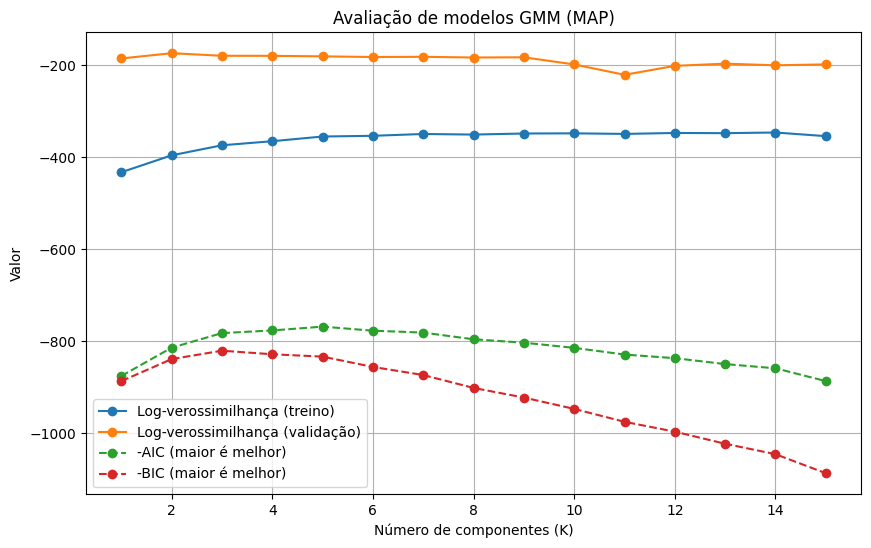


- Melhor K (BIC): 3
- Melhor K (AIC): 5
- Melhor K (Validação): 2



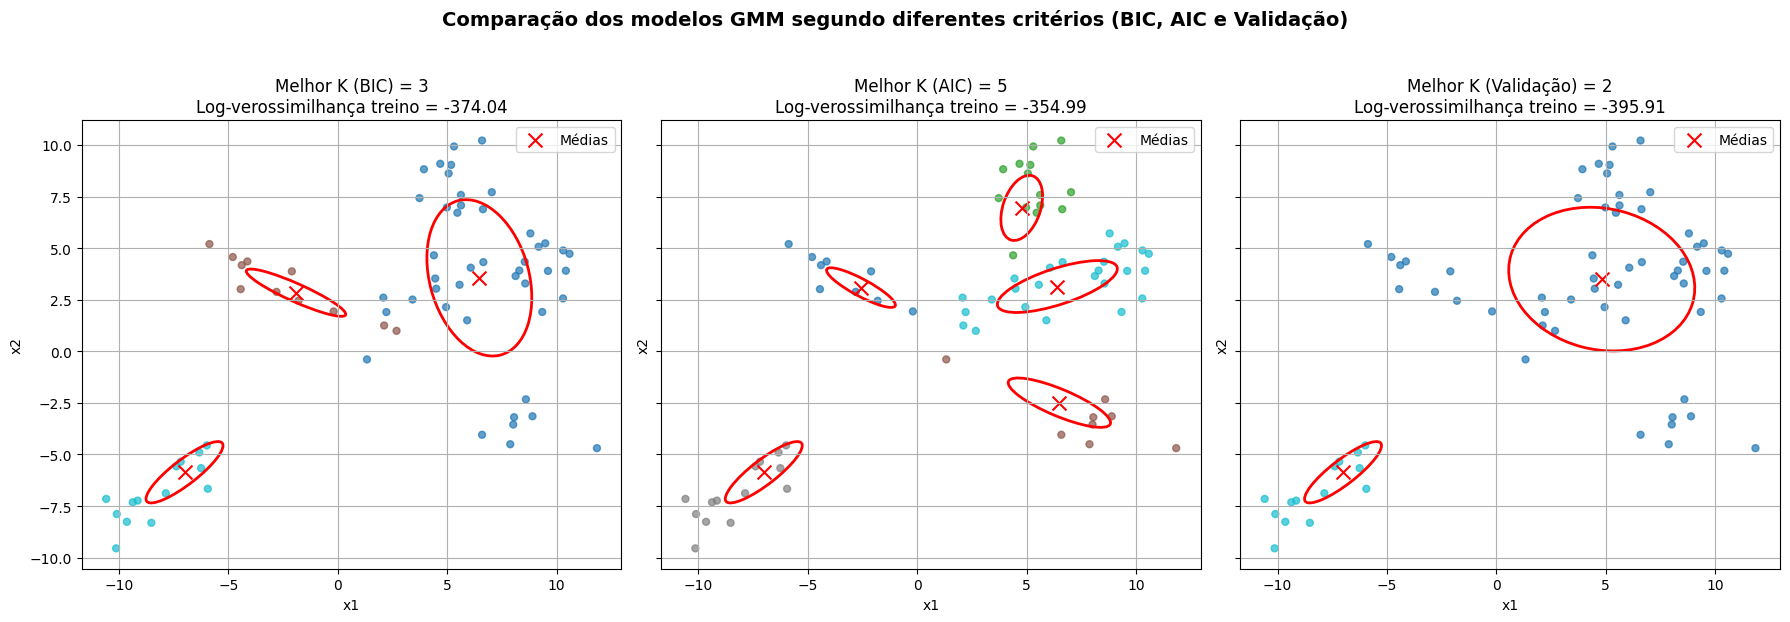

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.patches import Ellipse

# --------------------------------------------------------------
# 1. Carregando os dados
# Lê o arquivo CSV contendo os dados bidimensionais.
# --------------------------------------------------------------
data = np.genfromtxt('clustering_data.csv', delimiter=',')
print(f"Dados carregados! Formato = {data.shape}")

# --------------------------------------------------------------
# 2. Dividindo os dados em treino e validação
# Essa divisão nos permite calcular a log-verossimilhança fora
# do treino, avaliando a capacidade de generalização do modelo.
# --------------------------------------------------------------
X_train, X_val = train_test_split(data, test_size=0.3, random_state=42)
N_train, D = X_train.shape

# --------------------------------------------------------------
# 3. Definição das funções auxiliares
# --------------------------------------------------------------

def gaussian_pdf(X, mean, cov):
  # Calcula a densidade de probabilidade da Gaussiana multivariada.
  D = X.shape[1]
  det_cov = np.linalg.det(cov)
  # Prevenção contra singularidade (pode ocorrer com Nk pequeno)
  if det_cov <= 0:
    cov += np.eye(D) * 1e-6
    det_cov = np.linalg.det(cov)
    if det_cov <= 0:
      raise ValueError("Covariância singular!")

  inv_cov = np.linalg.inv(cov)
  norm_const = 1.0 / np.sqrt((2 * np.pi) ** D * det_cov)
  diff = X - mean
  # O uso de sum(diff @ inv_cov * diff) é um truque eficiente para a forma quadrática
  return norm_const * np.exp(-0.5 * np.sum(diff @ inv_cov * diff, axis=1))

def log_likelihood(X, pis, mus, covs):
  # Calcula a log-verossimilhança total dos dados.
  N = X.shape[0]
  K = len(pis)
  prob = np.zeros((N, K))
  for k in range(K):
    prob[:, k] = pis[k] * gaussian_pdf(X, mus[k], covs[k])
  # Adiciona epsilon para evitar log(0)
  return np.sum(np.log(prob.sum(axis=1) + 1e-12))

# ------------------------------------------------------------
# 4. Implementação do algoritmo EM com regularização (MAP)
# Executa o algoritmo EM (Expectation-Maximization) para GMM com uma leve abordagem MAP.
# alpha_dirichlet: prior Dirichlet para os pesos da mistura (regulariza π)
# lambda_mu: prior para as médias (puxa as médias para a média global)
# ------------------------------------------------------------
def gmm_em_map(X, K, alpha_dirichlet=1.0, lambda_mu=1.0, nu_wishart=None, max_iter=100, tol=1e-6, n_init=5):
  N, D = X.shape

  # Definimos um grau de liberdade mínimo para o prior Wishart (MAP da covariância)
  if nu_wishart is None:
    nu_wishart = D + 1. # Garante que o prior seja válido

  # Inicialização dos parâmetros
  best_params = None
  best_loglike = -np.inf

  for init in range(n_init):
    # Inicialização
    rng = np.random.default_rng(init)
    mus = X[rng.choice(N, K, replace=False)]
    # Inicializa covariâncias com a covariância global ligeiramente regularizada
    covs = np.array([np.cov(X.T) + np.eye(D)*1e-6 for _ in range(K)])
    pis = np.ones(K) / K
    prev_ll = -np.inf

    for it in range(max_iter):
      # E-step
      # Calcula as responsabilidades γ_nk = p(k|x_n)
      resp = np.zeros((N, K))
      for k in range(K):
        resp[:, k] = pis[k] * gaussian_pdf(X, mus[k], covs[k])
      resp_sum = resp.sum(axis=1, keepdims=True)
      # Adiciona epsilon para evitar divisão por zero
      resp = resp / (resp_sum + 1e-12)

      # M-step (MAP)
      # Nk: Contagens efetivas + prior Dirichlet
      Nk = resp.sum(axis=0) + alpha_dirichlet  # prior Dirichlet regulariza
      pis = Nk / Nk.sum()

      global_mean = X.mean(axis=0)
      for k in range(K):

        # M-step MAP para a Média (usando prior Gaussiano simplificado)
        # Atualiza média com prior (λ regula quão forte o prior influencia)
        # Aqui usamos soma ponderada (sem @) para evitar erro de dimensão
        weighted_sum_X = (resp[:, k][:, None] * X).sum(axis=0)
        mus[k] = (weighted_sum_X + lambda_mu * global_mean) / (Nk[k] + lambda_mu)

        # M-step MAP para a Covariância (adicionando prior Wishart simplificado)
        # O prior Wishart adiciona nu * Psi à soma ponderada dos desvios
        # Atualiza a covariância com regularização numérica
        diff = X - mus[k]

        # Soma ponderada dos desvios quadráticos (termo ML)
        weighted_cov_sum = (resp[:, k][:, None] * diff).T @ diff
        # Adiciona o prior (assumindo Psi como uma matriz identidade escalada para simplicidade)
        prior_psi = np.eye(D) * 1e-4 # Um pequeno valor para estabilidade/prior fraco

        # Fórmula M-step MAP Wishart: (Weighted_Cov_Sum + nu*Psi) / (Nk + nu + D + 1)
        # Simplificando a implementação:
        covs[k] = (weighted_cov_sum + prior_psi * nu_wishart) / (Nk[k] + nu_wishart)

        # Adição extra de ruído para garantir estabilidade absoluta, se necessário
        covs[k] += np.eye(D) * 1e-6

      # Log-verossimilhança para critério de parada
      ll = log_likelihood(X, pis, mus, covs)

      # Critério de parada
      if it > 0 and np.abs(ll - prev_ll) < tol:
        break
      prev_ll = ll

    if ll > best_loglike:
      best_params = (pis, mus, covs)
      best_loglike = ll

  return best_params, best_loglike

# ------------------------------------------------------------
# 5. Teste com diferentes números de componentes (K = 1 até 15)
# ------------------------------------------------------------
K_range = range(1, 16)
loglikes_train = []
loglikes_val = []
aic_values = []
bic_values = []

# Dicionário para armazenar os melhores parâmetros encontrados para cada K,
# para plotar os melhores Ks no final.
best_params_per_k = {}

for K in K_range:
  print(f"Treinando GMM com K={K} ...")
  (pis, mus, covs), ll_train = gmm_em_map(X_train, K)
  best_params_per_k[K] = (pis, mus, covs) # Salva os parâmetros

  # Avaliando no conjunto de validação
  ll_val = log_likelihood(X_val, pis, mus, covs)

  # Número de parâmetros do modelo (π, μ e covariâncias)
  # (K - 1) + K*D (médias) + K*D*(D + 1)/2 (covariâncias únicas)
  n_params = (K - 1) + K * D + K * D * (D + 1) / 2
  N = X_train.shape[0]

  # Critérios de informação
  aic = -2 * ll_train + 2 * n_params
  bic = -2 * ll_train + np.log(N) * n_params

  # Salvando os resultados
  loglikes_train.append(ll_train)
  loglikes_val.append(ll_val)
  aic_values.append(aic)
  bic_values.append(bic)

# ------------------------------------------------------------
# 6. Plotando AIC, BIC e log-verossimilhança
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
plt.plot(K_range, loglikes_train, 'o-', label='Log-verossimilhança (treino)')
plt.plot(K_range, loglikes_val, 'o-', label='Log-verossimilhança (validação)')
# Plotamos -AIC e -BIC para que "maior valor" signifique "melhor modelo" no gráfico
plt.plot(K_range, -np.array(aic_values), 'o--', label='-AIC (maior é melhor)')
plt.plot(K_range, -np.array(bic_values), 'o--', label='-BIC (maior é melhor)')
plt.xlabel('Número de componentes (K)')
plt.ylabel('Valor')
plt.title('Avaliação de modelos GMM (MAP)')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 7. Selecionando os melhores modelos
# ------------------------------------------------------------
# Encontrando o índice do melhor valor (o menor AIC/BIC ou maior LL_val)
best_k_bic = K_range[np.argmin(bic_values)]
best_k_aic = K_range[np.argmin(aic_values)]
best_k_val = K_range[np.argmax(loglikes_val)]

print(f"\n- Melhor K (BIC): {best_k_bic}")
print(f"- Melhor K (AIC): {best_k_aic}")
print(f"- Melhor K (Validação): {best_k_val}\n")

# ------------------------------------------------------------
# 8. Definição da função de visualização
# ------------------------------------------------------------
def plot_gmm_clusters(ax, X, pis, mus, covs, title):
  # Gera um scatter plot com os clusters encontrados e as elipses das Gaussianas.
  N, D = X.shape
  K = len(pis)

  # Calcula as responsabilidades para colorir os pontos
  resp = np.zeros((N, K))
  for k in range(K):
    resp[:, k] = pis[k] * gaussian_pdf(X, mus[k], covs[k])
  labels = np.argmax(resp, axis=1)

  # Plota os pontos e médias
  ax.scatter(X[:,0], X[:,1], c=labels, cmap='tab10', s=25, alpha=0.7)
  ax.scatter(mus[:,0], mus[:,1], c='red', marker='x', s=100, label='Médias')

  # Desenha elipses de 1σ (representando a incerteza de cada componente)
  for k in range(K):
    # autovalores e autovetores da covariância para obter largura/altura e orientação
    vals, vecs = np.linalg.eigh(covs[k])
    # garantir ordem decrescente (maior eixo primeiro)
    order = np.argsort(vals)[::-1]
    vals = vals[order]
    vecs = vecs[:,order]

    # angle: direção do primeiro autovetor (em graus)
    angle = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))

    # width e height = 2 * sqrt(eigenvalues) para o raio 1σ (fator 2 dá diâmetro)
    # Fator de 2.0 para desenhar o diâmetro de 1-sigma
    width = 2.0 * np.sqrt(vals[0])
    height = 2.0 * np.sqrt(vals[1])

    # xy deve ser uma tupla (x, y) e angle nomeado — assim evitamos ambiguidades
    xy = (mus[k, 0], mus[k, 1])

    ell = Ellipse(xy=xy, width=width, height=height, angle=angle, edgecolor='red', facecolor='none', lw=2)
    ax.add_patch(ell)

  ll = log_likelihood(X, pis, mus, covs)
  ax.set_title(f"{title}\nLog-verossimilhança treino = {ll:.2f}")
  ax.set_xlabel("x1")
  ax.set_ylabel("x2")
  ax.grid(True)
  ax.legend()

# ------------------------------------------------------------
# 9. Visualizando os agrupamentos para os Ks escolhidos
# ------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Parâmetros para o melhor K do BIC
pis_bic, mus_bic, covs_bic = best_params_per_k[best_k_bic]
plot_gmm_clusters(axes[0], X_train, pis_bic, mus_bic, covs_bic, f"Melhor K (BIC) = {best_k_bic}")

# Parâmetros para o melhor K do AIC
pis_aic, mus_aic, covs_aic = best_params_per_k[best_k_aic]
plot_gmm_clusters(axes[1], X_train, pis_aic, mus_aic, covs_aic, f"Melhor K (AIC) = {best_k_aic}")

# Parâmetros para o melhor K da Validação
pis_val, mus_val, covs_val = best_params_per_k[best_k_val]
plot_gmm_clusters(axes[2], X_train, pis_val, mus_val, covs_val, f"Melhor K (Validação) = {best_k_val}")

# Título geral da figura
fig.suptitle("Comparação dos modelos GMM segundo diferentes critérios (BIC, AIC e Validação)", fontsize=14, fontweight='bold', y=1.03)

plt.tight_layout()
plt.show()


# Conclusão

Nesta atividade, implementei a solução **MAP (Maximum a Posteriori)** para o **GMM (Gaussian Mixture Model)** e avaliei o desempenho do modelo variando o número de componentes K de 1 até 15. Para cada valor de K, calculei as métricas **AIC, BIC, log-verossimilhança de treino e log-verossimilhança de validação**, que me ajudaram a entender como o número de componentes influencia o ajuste do modelo.

Minha análise inicial, com uma regularização MAP mais simples, indicou que \(K=3\) era o melhor valor para o BIC e para a validação. No entanto, ao refinar a implementação com a inclusão de priors mais robustos para as covariâncias (via Wishart simplificado), os resultados mudaram sutilmente, mostrando como a força da regularização afeta a escolha do modelo ideal.

Os critérios de seleção, indicaram diferentes números de componentes:

- BIC (Bayesian Information Criterion): Escolheu \(K=3\). Esse critério é bem rigoroso e prefere modelos mais simples, então achou que o \(K=3\) era o melhor meio-termo entre ser preciso e ser simples.
- AIC (Akaike Information Criterion): Indicou \(K=5\). Este critério penaliza menos a complexidade e preferiu o modelo que alcança a melhor log-verossimilhança de treino, ajustando-se mais aos detalhes finos dos dados.
- Log-verossimilhança de Validação: Indicou \(K=2\). Este foi o resultado mais impactante. Com a regularização MAP mais forte, o conjunto de validação preferiu o modelo mais simples de todos, sugerindo que \(K=2\) generaliza melhor para dados não vistos.

Visualmente, o modelo com \(K=5\) (imagem central) foi o que melhor "encaixou" as elipses nos grupos de pontos do treino, capturando detalhes mais finos, mas correndo o risco de overfitting. O modelo com \(K=3\) (imagem esquerda) ofereceu um meio-termo, enquanto o modelo com \(K=2\) (imagem direita) é o mais simplista.

Portanto, no contexto deste aprendizado, os resultados mostram um conflito claro entre os critérios, mas a preferência do conjunto de validação pelo modelo \(K=2\) ou \(K=3\) (dependendo da regularização usada) sugere que um modelo mais simples é o mais adequado para generalização, alcançando um bom equilíbrio entre ajuste e simplicidade.

Essa atividade me ajudou a compreender melhor como os critérios de seleção de modelos atuam na prática e como o GMM pode ser sensível não apenas à escolha do número de componentes, mas também à forma como o algoritmo é regularizado.